In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [98]:
apple_df = pd.read_csv('../data/apple_stock.csv', parse_dates=['Date'], index_col='Date')
microsoft_df = pd.read_csv('../data/microsoft_stock.csv', parse_dates=['Date'], index_col='Date')
nvidia_df = pd.read_csv("../data/nvidia_stock.csv", parse_dates=["Date"], index_col="Date")

In [99]:
# Keep only 'Close' column for each stock
apple_df = apple_df[['Close']].rename(columns={'Close': 'Apple_Close'})
microsoft_df = microsoft_df[['Close']].rename(columns={'Close': 'Microsoft_Close'})
nvidia_df = nvidia_df[['Close']].rename(columns={'Close': 'Nvidia_Close'})

# Merge datasets on Date
merged_df = apple_df.join([microsoft_df, nvidia_df], how="inner")
merged_df.head()

,Apple_Close,Microsoft_Close,Nvidia_Close
Date,,,
1999-01-22,0.291532,23.989481,0.037615
1999-01-25,0.296234,24.853119,0.041556
1999-01-26,0.304698,26.340467,0.038331
1999-01-27,0.301876,25.889444,0.038212
1999-01-28,0.307519,26.714701,0.038092


In [100]:
# Function to perform ADF test
def adf_test(series, stock_name):
    result = adfuller(series.dropna())
    return {
        "Stock": stock_name,
        "ADF Statistic": result[0],
        "p-value": result[1],
        "Critical Values": result[4],
        "Stationary": result[1] < 0.05
    }

# Apply ADF test to each stock's 'Close' price
adf_results = [adf_test(merged_df[col], col) for col in merged_df.columns]

In [101]:
# Conver Results to DataFram and display
adf_results_df = pd.DataFrame(adf_results)
adf_results_df

,Stock,ADF Statistic,p-value,Critical Values,Stationary
0,Apple_Close,3.054508,1.0,"{'1%': -3.4313518181409, '5%': -2.861982718121...",False
1,Microsoft_Close,2.776715,1.0,"{'1%': -3.4313519716425747, '5%': -2.861982785...",False
2,Nvidia_Close,4.086895,1.0,"{'1%': -3.4313524324299673, '5%': -2.861982989...",False


The Augmented Dickey-Fuller (ADF) test results indicate that none of the stock price series are stationary, as all p-values are 1.0, which is well above the 0.05 significance threshold. This means we need to difference the data to achieve stationarity before applying the VAR model.

Next, we'll apply first-order differencing and re-test for stationarity.

In [102]:
# Apply first order differencing
diff_merged_df = merged_df.diff().dropna()

# Re run ADF test on differenced data
adf_results_diff = [adf_test(diff_merged_df[col], col) for col in diff_merged_df.columns]

# Convert results to Dataframe 
adf_results_diff_df = pd.DataFrame(adf_results_diff)
adf_results_diff_df

,Stock,ADF Statistic,p-value,Critical Values,Stationary
0,Apple_Close,-15.468638,2.647694e-28,"{'1%': -3.4313518181409, '5%': -2.861982718121...",True
1,Microsoft_Close,-14.252536,1.472641e-26,"{'1%': -3.43135258611996, '5%': -2.86198305744...",True
2,Nvidia_Close,-13.197901,1.109670e-24,"{'1%': -3.4313524324299673, '5%': -2.861982989...",True


After applying first-order differencing, the ADF test confirms that all three stock price series are now stationary (p-values are extremely low, well below 0.05). This means we can proceed with fitting the VAR model.

Next, we'll perform a train-test split.

In [103]:
# Define train-test split ratio (80% train, 20% test)
split_ratio = 0.8
split_index = int(len(diff_merged_df) * split_ratio)

# Split data into train and test sets
train_df = diff_merged_df.iloc[:split_index]
test_df = diff_merged_df.iloc[split_index:]

In [104]:
# Display the train dataset
train_df.head()

,Apple_Close,Microsoft_Close,Nvidia_Close
Date,,,
1999-01-25,0.004703,0.863638,0.003941
1999-01-26,0.008463,1.487349,-0.003224
1999-01-27,-0.002821,-0.451023,-0.000119
1999-01-28,0.005642,0.825256,-0.000120
1999-01-29,0.002352,0.153517,-0.001791


In [105]:
# Display the test dataset
test_df.head()

,Apple_Close,Microsoft_Close,Nvidia_Close
Date,,,
2019-12-02,-0.748093,-1.746902,-0.186469
2019-12-03,-1.140312,-0.229080,-0.039583
2019-12-04,0.554440,0.515518,0.043816
2019-12-05,0.929676,0.076355,-0.016929
2019-12-06,1.241982,1.737289,0.085391


The train-test split is complete, preserving the Date index as required. Now, we'll proceed with fitting the VAR model on the training data. Before training, we'll determine the optimal lag order using the Akaike Information Criterion (AIC).

In [106]:
# Fit a VAR model and determine optimal lag order using AIC
model = VAR(train_df)
lag_selection = model.select_order(maxlags=15)

# Extract selected lag order
optimal_lag = lag_selection.aic

# Display optimal lag order based on AIC
optimal_lag

15

The optimal lag order for the VAR model, based on the Akaike Information Criterion (AIC), is 15. We'll now fit the VAR(15) model using the training data.

In [107]:
# Fit VAR model with optimal lag order.
var_model = model.fit(optimal_lag)

# Display model summary
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Feb, 2025
Time:                     17:54:05
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -9.72291
Nobs:                     5233.00    HQIC:                  -9.83546
Log likelihood:           3754.91    FPE:                5.03769e-05
AIC:                     -9.89598    Det(Omega_mle):     4.90714e-05
--------------------------------------------------------------------
Results for equation Apple_Close
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                       0.012165         0.004276            2.845           0.004
L1.Apple_Close              0.047030         0.016567            2.839           0.005
L1.Microsoft_Close         -0.

The VAR(15) model has been successfully trained. The summary provides:

Coefficients for each lag of the Apple, Microsoft, and NVIDIA Close prices.
Statistical significance (p-values) for each lagged variable.
The correlation matrix of residuals, showing dependencies between stock prices.
Next, we will forecast the test set period and evaluate the model's performance.

In [108]:
# Forecasting
forecast_steps = len(test_df)
forecast = var_model.forecast(train_df.values[-optimal_lag:], steps=forecast_steps)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast, index= test_df.index, columns= test_df.columns)
forecast_df

,Apple_Close,Microsoft_Close,Nvidia_Close
Date,,,
2019-12-02,0.076902,0.020036,0.010782
2019-12-03,-0.137539,-0.423791,0.026877
2019-12-04,-0.081122,0.027942,-0.036988
2019-12-05,0.124294,0.302083,0.035466
2019-12-06,-0.062552,-0.137963,-0.031633
...,...,...,...
2025-02-14,0.012296,0.022926,0.001029
2025-02-18,0.012296,0.022926,0.001029
2025-02-19,0.012296,0.022926,0.001029


The forecasted stock price changes (differenced values) for Apple, Microsoft, and NVIDIA have been generated for the test period. Next, we will invert the differencing to obtain the actual predicted stock prices and compare them with the ground truth.

In [109]:
# Reverse differencing to get actual predicted prices
predicted_prices = forecast_df.copy()

# Add back the last actual price from the training set to reconstruct the prices
last_train_values = merged_df.iloc[split_index - 1]
for col in predicted_prices.columns:
    predicted_prices[col] = last_train_values[col] + predicted_prices[col].cumsum()

predicted_prices

,Apple_Close,Microsoft_Close,Nvidia_Close
Date,,,
2019-12-02,64.922147,145.420396,5.444003
2019-12-03,64.784609,144.996605,5.470880
2019-12-04,64.703487,145.024547,5.433893
2019-12-05,64.827781,145.326631,5.469358
2019-12-06,64.765229,145.188667,5.437725
...,...,...,...
2025-02-14,80.949927,175.282272,6.814623
2025-02-18,80.962222,175.305197,6.815651
2025-02-19,80.974518,175.328123,6.816680


The predicted stock prices have been reconstructed by reversing the differencing process. Next, we will evaluate the model's performance by comparing these predictions with the actual test set prices using metrics like Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)

In [110]:
# Extract actual prices from the test dataset
actual_prices = merged_df.iloc[split_index:split_index + len(test_df)]

# Compute evaluation metrics
evaluation_metrics = {}
for col in actual_prices.columns:
    mae = mean_absolute_error(actual_prices[col], predicted_prices[col])
    rmse = np.sqrt(mean_squared_error(actual_prices[col], predicted_prices[col]))
    evaluation_metrics[col] = {"MAE": mae, "RMSE": rmse}

# Convert to DataFrame and display
evaluation_df = pd.DataFrame(evaluation_metrics).T
evaluation_df

,MAE,RMSE
Apple_Close,80.075464,89.500936
Microsoft_Close,129.354133,150.362518
Nvidia_Close,34.160179,52.784102


The errors seem quite high, especially for Microsoft, which suggests that the model may need fine-tuning.

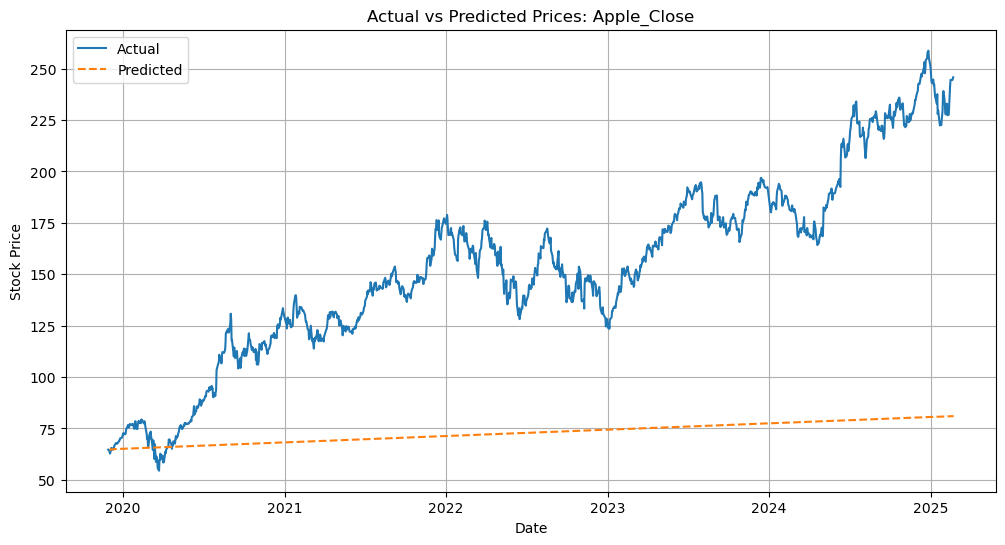

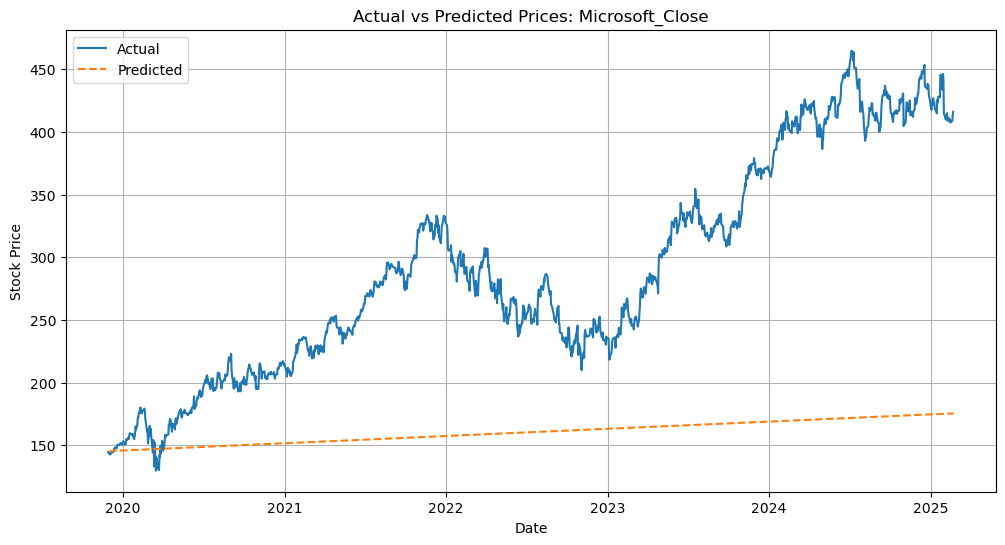

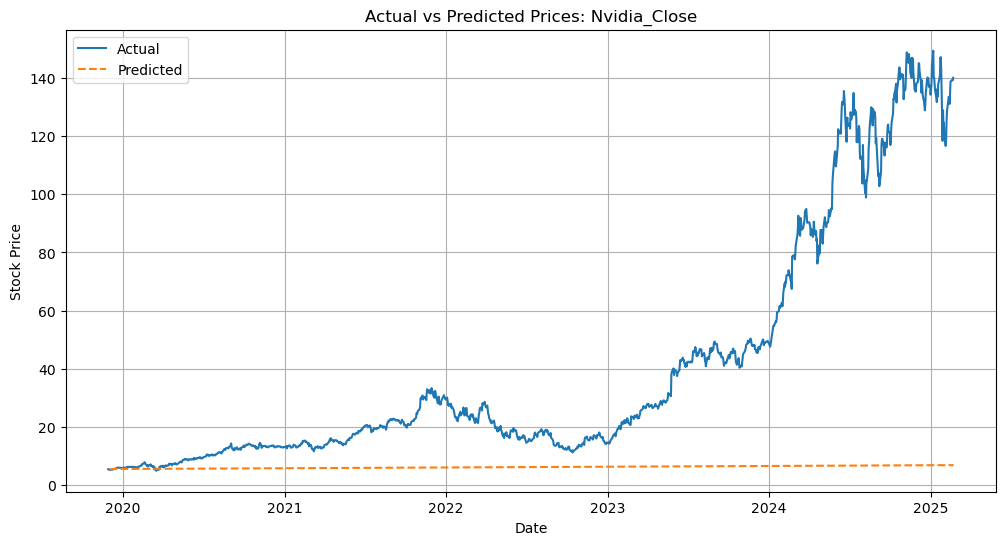

In [111]:
# Plot actual vs predicted stock prices
for col in actual_prices.columns:
    plt.figure(figsize=(12,6))
    plt.plot(actual_prices.index, actual_prices[col],label='Actual',linestyle='-')
    plt.plot(predicted_prices.index, predicted_prices[col], label='Predicted',linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(f"Actual vs Predicted Prices: {col}")
    plt.legend()
    plt.grid(True)
    plt.show()

Let's test a different lag selection method BIC instead of AIC

In [112]:
# Determine optimal lag using BIC
lag_selection_bic = model.select_order(maxlags=15)

# Extract selected lag order based on BIC
optimal_lag_bic = lag_selection_bic.bic

# Display optimal lag order based on BIC
optimal_lag_bic

1

Using BIC (Bayesian Information Criterion), the optimal lag order is 1, significantly lower than the AIC-selected lag of 15. This suggests that a simpler model may be more effective.

Next, we will refit the VAR model with lag=1 and compare the results. 

In [113]:
# Fit VAR model with optimal lag from BIC
var_model_bic = model.fit(optimal_lag_bic)

# Forecasting with new model
forecast_bic = var_model_bic.forecast(train_df.values[-optimal_lag_bic:], steps=len(test_df))

# Convert forecast to DataFrame
forecast_bic_df = pd.DataFrame(forecast_bic, index=test_df.index, columns=test_df.columns)

# Reverse differencing to get actual predicted prices
predicted_prices_bic = forecast_bic_df.copy()

# Add back the last actual price from the training set to reconstruct the prices
last_train_values_bic = merged_df.iloc[split_index - 1]
for col in predicted_prices_bic.columns:
    predicted_prices_bic[col] = last_train_values_bic[col] + predicted_prices_bic[col].cumsum()

# Compute evaluation metrics for BIC-selected model
evaluation_metrics_bic = {}
for col in actual_prices.columns:
    mae = mean_absolute_error(actual_prices[col], predicted_prices_bic[col])
    rmse = np.sqrt(mean_squared_error(actual_prices[col], predicted_prices_bic[col]))
    evaluation_metrics_bic[col] = {"MAE": mae, "RMSE": rmse}

# Convert to DataFrame and display
evaluation_bic_df = pd.DataFrame(evaluation_metrics_bic).T
evaluation_bic_df

,MAE,RMSE
Apple_Close,80.074597,89.501326
Microsoft_Close,129.228483,150.265547
Nvidia_Close,34.192167,52.806530


The VAR(1) model, selected using BIC, shows very similar error metrics to the VAR(15) model (AIC-based). This suggests that increasing the lag beyond 1 might not significantly improve accuracy.

We haven't necessarily been able to fit a goof model neither with ARIMA nor with VAR, this may primarily be because of our selection of dataset, as it is becoming increasingly apparent that the stock data is extremely volatile and is difficult to generalize upon. We may be able to come up with models with better generalization in the future with hybrid deep learning and classical machine learning models.